<a href="https://colab.research.google.com/github/VavRe/nndl-ut/blob/main/CA6/NNDL_HW6_ACGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras 
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,ReLU,Reshape,Input,Concatenate,Embedding,Activation,multiply,UpSampling2D
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.optimizers import Adam


In [ ]:
# from tensorflow.keras.utils import image_dataset_from_directory
# dataset = image_dataset_from_directory('/content/drive/MyDrive/NNDL-UT/HW6/Dataset',image_size=(32,32),color_mode="grayscale")

(1005, 32, 32, 1)

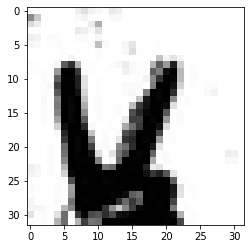

In [ ]:
images = []
classes = []
for (root,dirs,files) in os.walk('/content/drive/MyDrive/NNDL-UT/HW6/Dataset', topdown=True):
  for filename in files:
    images.append(cv2.imread(os.path.join(root, filename),cv2.IMREAD_GRAYSCALE))
    classes.append(int(root.split('/')[-1][-1]))
images = np.array(images)
plt.imshow(images[1004], cmap='gray_r')
images = np.expand_dims(images, -1)
images = images.astype('float32')
images = ( images - 127.5 ) / 127.5
classes = np.array(classes)
classes = np.expand_dims(classes,-1)
images.shape

## Global Configs

In [ ]:
img_shape = (32,32,1)
num_classes = 5
latent_dim = 100
init = RandomNormal(stddev=0.02)
lr=0.00000000002
beta = 0.5

## Discriminator Model

In [ ]:
def build_discriminator():
  
  disc_model = Sequential()
  input_img = Input(shape=img_shape)
  
  # Downsample to 16x16
  d_f_model = Conv2D(16, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(input_img)
  d_f_model = LeakyReLU(alpha=0.2)(d_f_model)
  d_f_model = Dropout(0.5)(d_f_model)
  
  # Normal it
  d_f_model = Conv2D(32, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(d_f_model)
  d_f_model = BatchNormalization()(d_f_model)
  d_f_model = LeakyReLU(alpha=0.2)(d_f_model)
  d_f_model = Dropout(0.5)(d_f_model)
  
  # Downsample to 8x8
  d_f_model = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d_f_model)
  d_f_model = BatchNormalization()(d_f_model)
  d_f_model = LeakyReLU(alpha=0.2)(d_f_model)
  d_f_model = Dropout(0.5)(d_f_model)
  
  # Normal it
  d_f_model = Conv2D(128, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(d_f_model)
  d_f_model = BatchNormalization()(d_f_model)
  d_f_model = LeakyReLU(alpha=0.2)(d_f_model)
  d_f_model = Dropout(0.5)(d_f_model)
 
  # Downsample to 4x4
  d_f_model = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d_f_model)
  d_f_model = BatchNormalization()(d_f_model)
  d_f_model = LeakyReLU(alpha=0.2)(d_f_model)
  d_f_model = Dropout(0.5)(d_f_model)
 
  # Normal it
  d_f_model = Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_initializer=init)(d_f_model)
  d_f_model = BatchNormalization()(d_f_model)
  d_f_model = LeakyReLU(alpha=0.2)(d_f_model)
  d_f_model = Dropout(0.5)(d_f_model)
  
  # Finalizing
  d_f_model = Flatten()(d_f_model)
  
  # Outputs
  realness_output = Dense(1,activation="sigmoid")(d_f_model)
  label_output = Dense(num_classes,activation="softmax")(d_f_model)
 
  # Compile
  disc_model = Model(input_img,[realness_output,label_output])
  disc_opt = Adam(lr=lr,beta_1=beta)
  disc_loss = ['binary_crossentropy', 'sparse_categorical_crossentropy']
  disc_model.compile(loss=disc_loss,optimizer=disc_opt)
  
  return disc_model


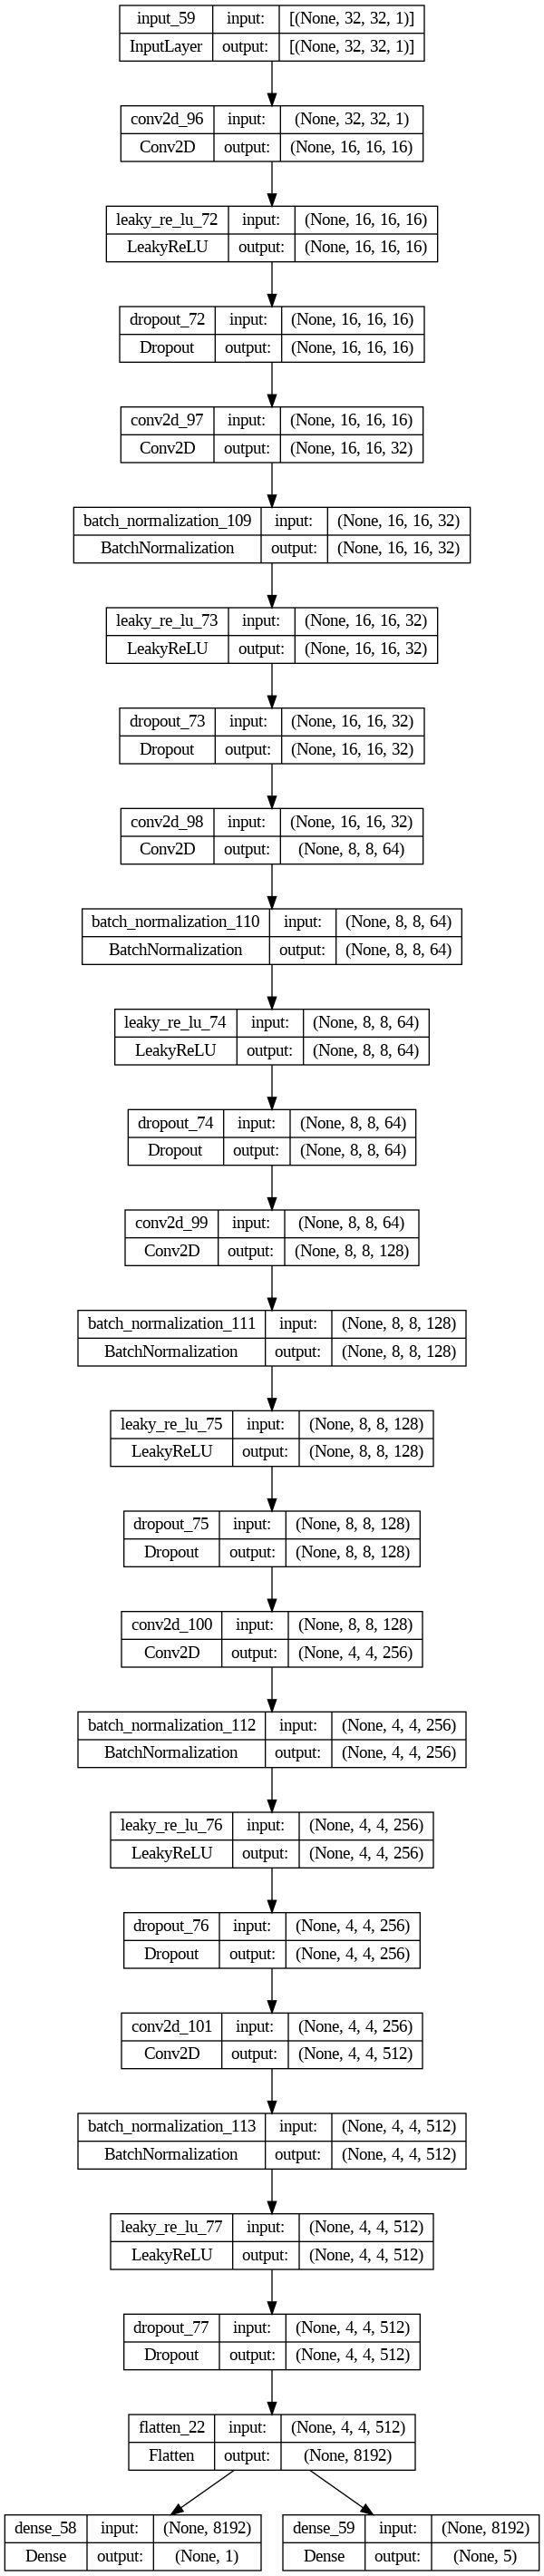

In [ ]:
disc_test = build_discriminator()
plot_model(disc_test, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Generator Model

In [ ]:
def build_generator():
  # Making Embeddings for input label input
  gen_label_input_shape = Input(shape=(1,))
  gen_label_input = Embedding(num_classes,30)(gen_label_input_shape)
  gen_label_input = Dense(4*4*1, kernel_initializer=init)(gen_label_input)
  gen_label_input = Reshape((4,4,1))(gen_label_input)
  # Taking care of Noises of Latent Dim
  gen_noise_input_shape = Input(shape=(latent_dim,))
  gen_noise_input = Dense(4*4*384, activation="ReLU")(gen_noise_input_shape)
  gen_noise_input = Reshape((4,4,384))(gen_noise_input)
  # Generator Input
  gen_input = Concatenate()([gen_noise_input,gen_label_input])
  # Upsample to 8x8
  g_f_model = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen_input)
  g_f_model = BatchNormalization()(g_f_model)
  g_f_model = Activation('relu')(g_f_model)
  # Upsample to 16x16
  g_f_model = Conv2DTranspose(96, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(g_f_model)
  g_f_model = BatchNormalization()(g_f_model)
  g_f_model = Activation('relu')(g_f_model)
  # Upsample to 32x32
  g_f_model = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(g_f_model)
  gen_output = Activation('tanh')(g_f_model)

  # Define Model
  gen_model = Model([gen_noise_input_shape, gen_label_input_shape], gen_output)

  return gen_model

In [ ]:
# def build_generator():

#         model = Sequential()

#         model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
#         model.add(Reshape((8, 8, 128)))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(UpSampling2D())
#         model.add(Conv2D(128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(UpSampling2D())
#         model.add(Conv2D(64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Conv2D(1, kernel_size=3, padding='same'))
#         model.add(Activation("tanh"))

#         model.summary()

#         noise = Input(shape=(latent_dim,))
#         label = Input(shape=(1,), dtype='int32')
#         label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

#         model_input = multiply([noise, label_embedding])
#         img = model(model_input)

#         return Model([noise, label], img)

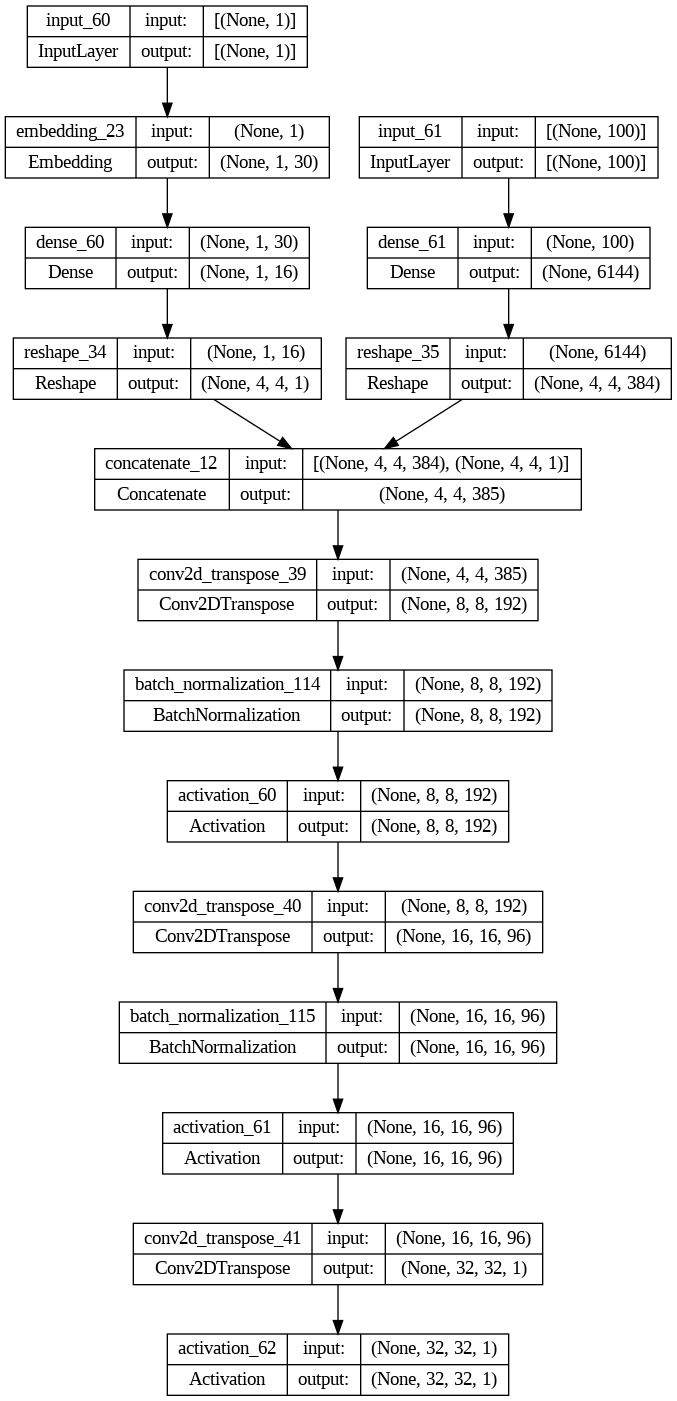

In [ ]:
gen_test = build_generator()
plot_model(gen_test, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

### Define GAN

In [ ]:
def build_gan(generator_,discriminator):
  
  # for layer in discriminator.layers:
  #   if not isinstance(layer, BatchNormalization):
  #     layer.trainable = False
  discriminator.trainable = False
  gan_output = discriminator(generator_.output)
  model = Model(generator_.input , gan_output)
  optimizer = Adam(lr=lr,beta_1=beta)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=optimizer)
  	
  return model

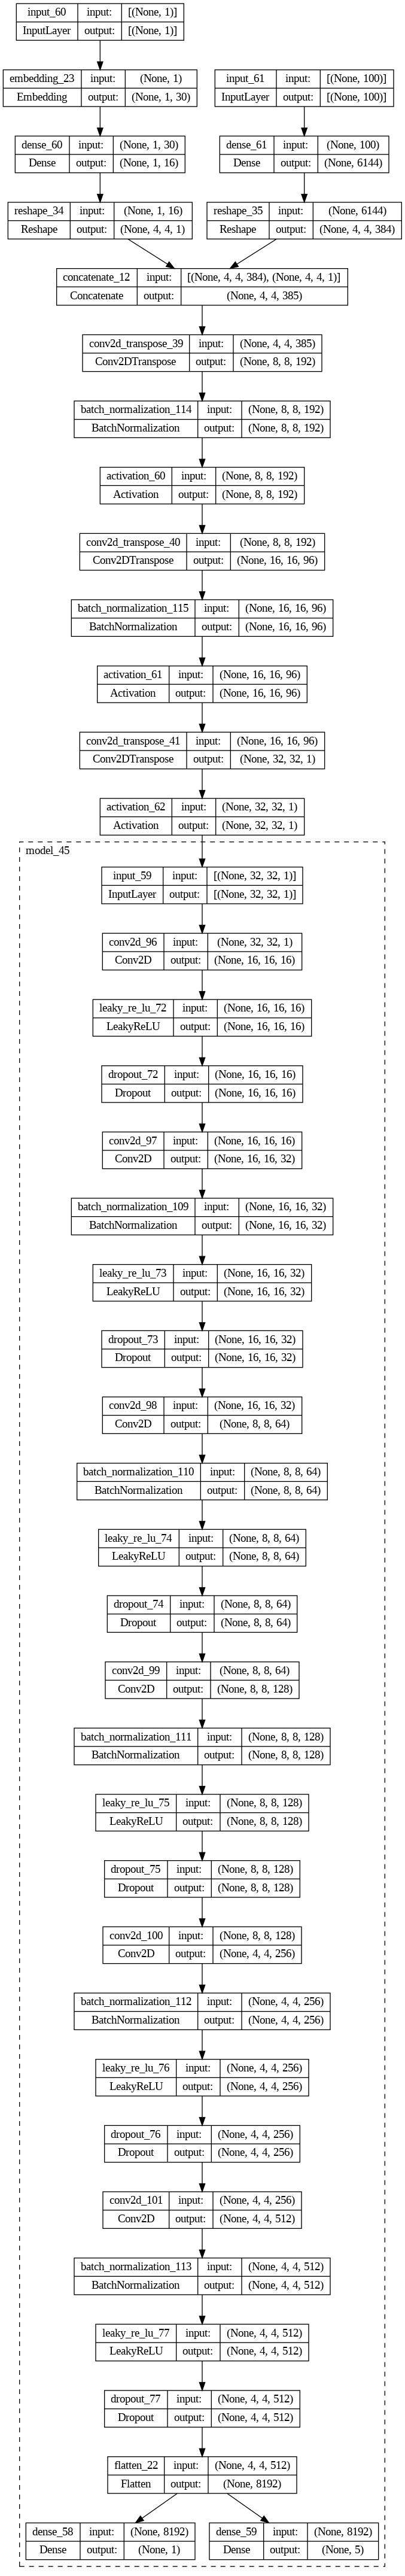

In [ ]:
gan_model_test = build_gan(gen_test,disc_test) 
tf.keras.utils.plot_model(
    gan_model_test,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

### Utility Functions

In [ ]:
from numpy.random import randint,randn
from numpy import ones,zeros

def get_real_samples(n_samples):
 
  index = randint(0,images.shape[0],n_samples)    # generate random index
  X , labels = images[index],classes[index] # get random images and labels
  y = ones((n_samples,1))
  
  return [X,labels],y

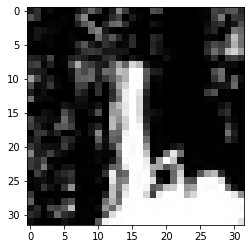

In [ ]:
real_data = get_real_samples(5)
plt.imshow(real_data[0][0][2][:,:,0], cmap="gray")

In [ ]:
real_data[0][1][2]

array([1])

In [ ]:
def get_latent_point(n_samples):
 
  x_inp = randn(n_samples * latent_dim)
  z_input = x_inp.reshape(n_samples, latent_dim)
  labels = randint(0,num_classes,n_samples)
 
  return [z_input,labels]

In [ ]:
def get_fake_samples(generator_, n_samples):
    
    z_input, labels = get_latent_point(n_samples)
    fake_images = generator_.predict([z_input,labels])
    y = zeros((n_samples,1))
    
    return [fake_images, labels], y

### Test Block

1/1 [==============================] - 0s 144ms/step


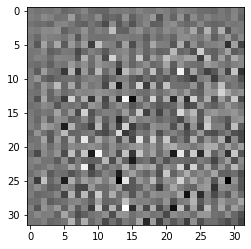

In [ ]:
genmod = build_generator()
fake_data = get_fake_samples(genmod, 30)
plt.imshow(fake_data[0][0][1][:,:,0], cmap="gray")


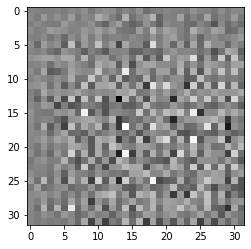

In [ ]:
plt.imshow(fake_data[0][0][2][:,:,0], cmap="gray")

### Save Generated Samples of GAN

In [ ]:
base_path = '/content/drive/MyDrive/NNDL-UT/HW6/results/ACGAN/'

def check_performance(step,generator_,n_samples=30):
  
  [imgs,_],_ = get_fake_samples(generator_, n_samples)
  imgs = (imgs + 1) / 2.0
  
  for i in range(30):
    plt.subplot(5,6,i+1)
    plt.axis('off')
    plt.imshow(imgs[i,:,:,0], cmap='gray_r')
  
  plot_filename = f'{base_path}generated_images-step_{step+1}'
  plt.savefig(plot_filename)
  plt.close()
  
  model_filename = f"{base_path}model-step_{step+1}.h5"
  generator_.save(model_filename)
  
  print(f"saved plot: {plot_filename}")
  print(f"saved model : { model_filename }")
  print("=========")

## Training

In [ ]:
# discrimintaor_model.output_shape

In [ ]:
# np.array([y_real,labels_real]).shape
# labels_real

In [ ]:
# Hyperparams

lr=0.00000000002
beta = 0.5
batch_size = 2
half_batch = int(batch_size / 2 )
batch_per_epoch = int(images.shape[0] / batch_size)
epochs = 400

# Model Instanciations

discrimintaor_model = build_discriminator()
generator_model = build_generator()
gan_model = build_gan(generator_model,discrimintaor_model)

gen_acc, disc_acc = list(), list()
gen_loss, disc_loss = list(), list()

for epoch in range(epochs):
  for batch in range(batch_per_epoch):
   
    # train the discriminator for half a batch on real data
    [ img_real , labels_real ] , y_real = get_real_samples(half_batch)
    disc_loss_real_sum , disc_loss_real_realness , disc_loss_real_labels = discrimintaor_model.train_on_batch( img_real ,[ y_real , labels_real ])
   
    # train the discriminator for half a batch on fake data
    [ img_fake , labels_fake ] , y_fake = get_fake_samples(generator_model , half_batch) 
    disc_loss_fake_sum , disc_loss_fake_realness , disc_loss_fake_labels = discrimintaor_model.train_on_batch(img_fake , [ y_fake , labels_fake ])
   
    [ z_input, z_labels ] = get_latent_point(batch_size)
    y_gan = ones((batch_size , 1))
    g_sum , gan_loss_realness, gan_loss_labels = gan_model.train_on_batch([ z_input , z_labels ] , [ y_gan , z_labels ])
    
    print("="*10)
    print(f"epoch: {epoch+1}/{epochs}")
    print(f"batch: {batch+1}/{batch_per_epoch}")
    print("Discriminator")
    print("="*10)
    print(f"realness-loss on reals: {disc_loss_real_realness} \n",f"labels-loss on reals: {disc_loss_real_labels }")
    print(f"realness-loss on fakes: {disc_loss_fake_realness} \n",f"labels-loss on fakes: {disc_loss_fake_labels }")
    print("="*10)
    print("GAN")
    print("="*10)
    print(f"realness-loss on reals: {gan_loss_realness} \n",f"labels-loss on reals: {gan_loss_labels }")

  if ( epoch ) % ( 3 ) == 0 :
    check_performance(epoch,generator_model)


1/1 [==============================] - 0s 136ms/step
epoch: 1/400
batch: 1/502
Discriminator
realness-loss on reals: 0.5311521291732788 
 labels-loss on reals: 2.636512279510498
realness-loss on fakes: 1.0184135437011719 
 labels-loss on fakes: 0.26828229427337646
GAN
realness-loss on reals: 0.6885707974433899 
 labels-loss on reals: 1.6115596294403076
1/1 [==============================] - 0s 14ms/step
epoch: 1/400
batch: 2/502
Discriminator
realness-loss on reals: 0.13508181273937225 
 labels-loss on reals: 3.256746530532837
realness-loss on fakes: 0.988223671913147 
 labels-loss on fakes: 5.592833995819092
GAN
realness-loss on reals: 0.6888914108276367 
 labels-loss on reals: 1.6082806587219238
1/1 [==============================] - 0s 14ms/step
epoch: 1/400
batch: 3/502
Discriminator
realness-loss on reals: 0.07007277756929398 
 labels-loss on reals: 4.5125732421875
realness-loss on fakes: 1.8984122276306152 
 labels-loss on fakes: 4.136643886566162
GAN
realness-loss on reals: 0.68

KeyboardInterrupt: ignored